Process edges for testing:
- Take in line data from Luis' team
- Translate and rotate

Tests in scope:
- Smoothed inflection point detection
- Downsampling + direct vector comparison
-

Set up basic test data:

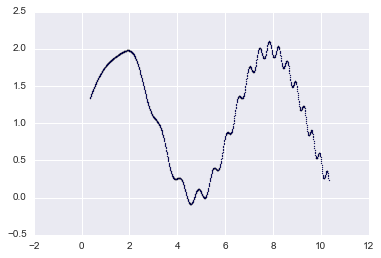

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

SMOOTHING_FACTOR = 30

X = np.arange(0,10,0.01)+0.34
Y = np.sin(X) + 0.1 * np.sin(X**2+3) + 1
testdata = np.array([X,Y]).T
plt.scatter(testdata[:,0],testdata[:,1], s=1)

In [105]:
def axis_align(inputdata):
    # Translate leftermost point to the origin
    translateddata = inputdata - inputdata[0]
    
    # Find an assumed "straight edge" line: 
    # straight line between first and last points
    leftpoint = translateddata[0]
    rightpoint = translateddata[-1]
    slope = (rightpoint[1] - leftpoint[1]) / (rightpoint[0] - leftpoint[0])
    
    # NOTE: can we get c,s more smartly?
    theta = np.arctan(slope)
    c, s = np.cos(theta), np.sin(theta)
    rotationmatrix = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    
    newdata =  translateddata * rotationmatrix
    # plt.scatter(newdata[:,0], newdata[:,1])
    
    scalefactor = newdata[-1,0]
    #print(scalefactor)
    newdata[:,0] = newdata[:,0] / scalefactor
    
    return newdata
    
aligned_data = axis_align(testdata)

We have processed lines.

Find locations of juts by smoothing locally (keep as variable smoothing parameter for now)

[ 0.15423938  0.43085204  0.4715077   0.47787571  0.73769031]


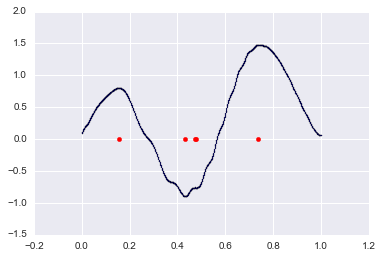

In [96]:
def _kernel_smoother(linedata, pointref, d):
    # Return the smoothed value of f(linedata[pointref])
    
    # Kernel average smoother: take the d nearest points on either side and use their f values
    # as a weighted average for f(x).
    leftlim = max(0, pointref - d)
    rightlim = min(len(linedata), pointref + d)

    weightwindow = np.concatenate( [np.array([(i+1) for i in range(pointref-leftlim)]),
                                   np.array([(d-i) for i in range(rightlim-pointref)])])
    weightwindow = weightwindow / np.sum(weightwindow)
    
    #print(np.sum(weightwindow)
    vals = linedata[leftlim: rightlim][:,1]
    #print(vals.shape, weightwindow.shape)
    #print(vals)
    fx = np.sum(np.multiply(np.squeeze(vals), weightwindow))
    #print(fx)
    return fx

def smooth(linedata):
    Xsmooth = np.array(linedata[:,0]).flatten()
    Ysmooth = [_kernel_smoother(linedata, i, SMOOTHING_FACTOR) for i in range(len(linedata))]
    testdata = np.array([Xsmooth, Ysmooth]).T
    return testdata

def inflection_anal(linedata):
    smoothed = smooth(linedata)
    gradients = np.gradient(smoothed[:,1])

    inflectionmask = [(gradients[i] * gradients[i+1] <= 0) for i in range(len(gradients)-1)]
    
    inflectionrefs = [i for i in range(len(inflectionmask)) if inflectionmask[i]]
    inflectionpoints = smoothed[inflectionrefs,0]
    
    return inflectionrefs, inflectionpoints

smoothed_data = smooth(aligned_data)
inflectionrefs, inflectionpoints = inflection_anal(aligned_data)
print(inflectionpoints)
plt.scatter(smoothed_data[:,0], smoothed_data[:,1], s=1)
plt.scatter(inflectionpoints,[0]*len(inflectionpoints), color='r')


In [97]:
def msdev(linedata):
    total = np.multiply(linedata[:,1], linedata[:,1])
    return np.sum(total)/len(linedata)

msdev(aligned_data)


0.63354434472063337

(3792, 2)
3601.99944475


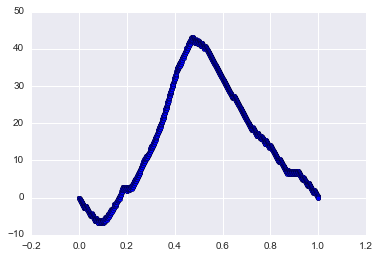

In [98]:
inputcsv = np.genfromtxt('sample_csv/74584_MS-DAR-00125-000-00073_north.csv', delimiter=',')
inputcsv = inputcsv[1:,(1,2)]
print(inputcsv.shape)

inputcsv.sort(0)

aligned_data = axis_align(inputcsv)

#plt.scatter(inputcsv[:,0],inputcsv[:,1])
plt.scatter(aligned_data[:,0], aligned_data[:,1])

In [99]:
msdev(aligned_data)

465.70302929059147

In [100]:
def get_aligneddata(filename):
    inputcsv = np.genfromtxt(filename, delimiter=',')
    inputcsv = inputcsv[1:,(1,2)]
    inputcsv.sort(0)
    aligned_data = axis_align(inputcsv)
    return aligned_data

def get_msdev(filename):
    return msdev(aligned_data)

In [101]:
import os 

for i in os.listdir("sample_csv"):
    name = "sample_csv/" + i
    print(name, msdev(get_aligneddata(name)))

3601.99944475
sample_csv/74584_MS-DAR-00125-000-00073_north.csv 465.703029291
3600.17013487
sample_csv/74584_MS-DAR-00125-000-00073_south.csv 6.8097390376
1084.17895202
sample_csv/74584_MS-DAR-00125-000-00073_west.csv 3408.17920444
3530.0239376
sample_csv/76748_MS-DAR-00053-00001-000-00118_north.csv 3.19860339829
3402.92242051
sample_csv/76748_MS-DAR-00053-00001-000-00118_south.csv 528.912322452
868.5
sample_csv/76748_MS-DAR-00053-00001-000-00118_west.csv 0.0
4000.06049954
sample_csv/77726_MS-DAR-00205-00001-000-00096_north.csv 1.96121793027
4013.50731904
sample_csv/77726_MS-DAR-00205-00001-000-00096_south.csv 9820.61101075


3792 3699


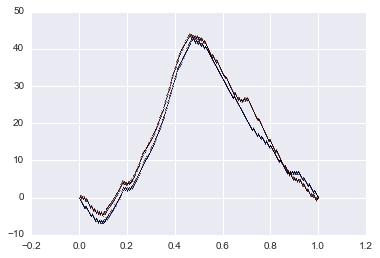

In [106]:
al1 = get_aligneddata("sample_csv/74584_MS-DAR-00125-000-00073_north.csv")
plt.scatter(al1[:,0], al1[:,1], s=0.1)

al2 = get_aligneddata("sample_csv/76748_MS-DAR-00053-00001-000-00118_south.csv")
plt.scatter(al2[:,0], al2[:,1], s=0.1, c='r')

print(len(al1), len(al2))

In [109]:
def sample_points(linedata):
    # Force point data into 1000 data points
    # Assumes x-values are mapped to [0,1]
    NUM_DEC_PLACES = 3
    def forceX(p):
        return (np.round(p[0], NUM_DEC_PLACES), p[1])
    
    
    
    def averageY(p):
        return 
    linedata = np.apply_along_axis(forceX, 1, linedata)
    return linedata

sample_points(aligned_data)

array([[  0.00000000e+00,   0.00000000e+00],
       [  1.00000000e-03,   9.76139966e-03],
       [  2.00000000e-03,   1.94687460e-02],
       ..., 
       [  9.97000000e-01,   4.68747817e-02],
       [  9.99000000e-01,   2.43313841e-02],
       [  1.00000000e+00,  -6.99594766e-17]])